**Part 1. AI Agent 이해와 입문 프로젝트**

- Chapter 02. LangGraph 기초 다지기

    - **📒[실습]** Clip 04. LangGraph 기본 사용법 - 노드와 엣지 연결

## 노드와 엣지 연결하기

In [1]:
from typing_extensions import TypedDict


class State(TypedDict):
    value_1: str
    value_2: int

In [2]:
def step_1(state: State):
    return {"value_1": state["value_1"]}


def step_2(state: State):
    current_value_1 = state["value_1"]
    return {"value_1": f"{current_value_1} b"}


def step_3(state: State):
    return {"value_2": 10}

In [3]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(step_1)
graph_builder.add_node(step_2)
graph_builder.add_node(step_3)

# 엣지 추가
graph_builder.add_edge(START, "step_1") # START ->1
graph_builder.add_edge("step_1", "step_2") # 1-> 2
graph_builder.add_edge("step_2", "step_3") # 2->3

In [4]:
graph = graph_builder.compile()

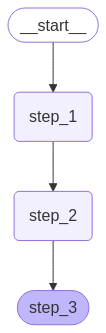

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"value_1": "fadgdsge"})

{'value_1': 'fadgdsge b', 'value_2': 10}

## 한번에 연결하기(add_sequence)

In [7]:
graph_builder = StateGraph(State).add_sequence([step_1, step_2, step_3])
graph_builder.add_edge(START, "step_1")

graph = graph_builder.compile()

graph.invoke({"value_1": "c"})

{'value_1': 'c b', 'value_2': 10}

## 병렬로 연결하기

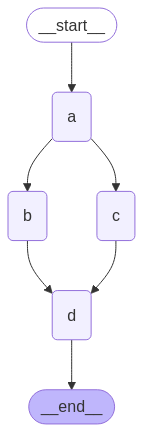

In [8]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add] # 업데이트 값이 뒤에 추가되도록 하는 operator.add 리듀서

In [9]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

In [10]:
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)

In [11]:
# 엣지 추가
graph_builder.add_edge(START, "a")
graph_builder.add_edge("a", "b") # a -> b
graph_builder.add_edge("a", "c") # a -> c
graph_builder.add_edge("b", "d") # b -> d
graph_builder.add_edge("c", "d") # c -> d
graph_builder.add_edge("d", END)
graph = graph_builder.compile()

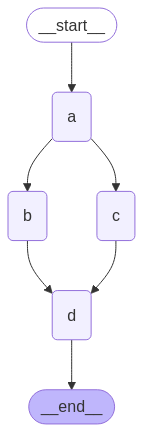

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke({"aggregate":[]})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

## 조건부 엣지 병렬 연결하기

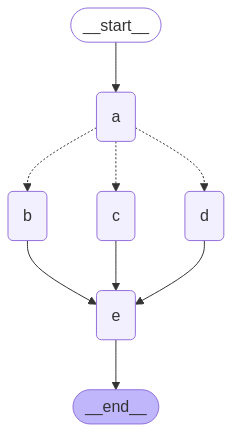

In [14]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    which: str

In [15]:
def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}


def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}


def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}


def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}


def e(state: State):
    print(f'Adding "E" to {state["aggregate"]}')
    return {"aggregate": ["E"]}

In [16]:
graph_builder = StateGraph(State)
graph_builder.add_node(a)
graph_builder.add_node(b)
graph_builder.add_node(c)
graph_builder.add_node(d)
graph_builder.add_node(e)
graph_builder.add_edge(START, "a")

In [17]:
# bc 혹은 cd 로 라우트를 결정하는 함수
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
graph_builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)

In [18]:
for node in intermediates:
    graph_builder.add_edge(node, "e")

graph_builder.add_edge("e", END)
graph = graph_builder.compile()

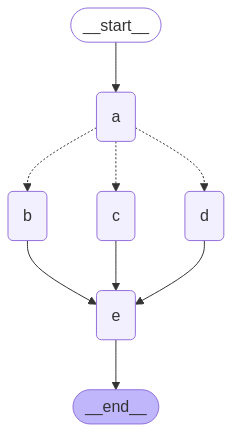

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "E" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'E'], 'which': 'bc'}

In [21]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding "A" to []
Adding "C" to ['A']
Adding "D" to ['A']
Adding "E" to ['A', 'C', 'D']


{'aggregate': ['A', 'C', 'D', 'E'], 'which': 'cd'}